# Linear Regression With Time Series

In [1]:
import pandas as pd

df = pd.read_csv(
    "C:/Users/ricar/OneDrive - Insper - Institudo de Ensino e Pesquisa/ECONOMIA/Time_Series/pasta/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Esta série registra o número de vendas de livros de capa dura em uma loja de varejo ao longo de 30 dias.

Durante o treinamento, o algoritmo de regressão aprende valores para os parâmetros `weight_1`, `weight_2` e `bias` que melhor se ajusta a `target`. (Esse algoritmo costuma ser chamado de mínimos quadrados ordinários, pois escolhe valores que minimizam o erro quadrático entre o alvo e as previsões.) Os pesos também são chamados de coeficientes de regressão e o viés também é chamado de interceptação porque informa onde o gráfico desse função cruza o eixo y.

### Time-step features

Existem dois tipos de recursos exclusivos para séries temporais: Time-step features (recursos de passo de tempo) e lag features (recursos de atraso).

Os recursos de **passo de tempo** são recursos que podemos derivar diretamente do índice de tempo. O recurso de passo de tempo mais básico é o dummy de tempo, que conta os passos de tempo na série do início ao fim. 

In [2]:
import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


A regressão linear com a dummy de tempo produz o modelo:

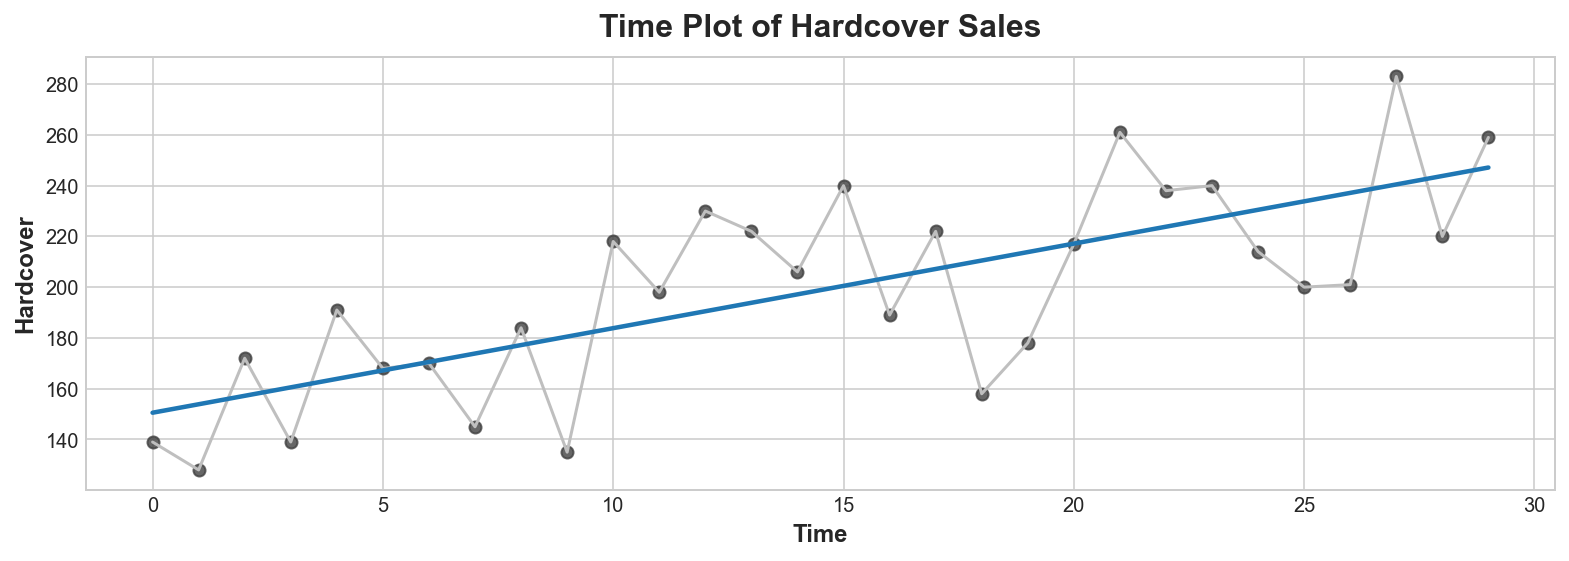

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');


Os recursos de passo de tempo permitem modelar a dependência do tempo. Uma série é dependente do tempo se seus valores podem ser previstos a partir do momento em que ocorreram. Na série Vendas de capa dura, podemos prever que as vendas no final do mês são geralmente maiores do que as vendas no início do mês.

### Lag Features

Para fazer um recurso de atraso, mudamos as observações da série alvo para que pareçam ter ocorrido mais tarde. Aqui, criamos um recurso de atraso de 1 etapa, embora também seja possível mudar em várias etapas.

In [5]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


A regressão linear com um recurso de atraso produz o modelo:

Portanto, os recursos de atraso nos permitem ajustar curvas a gráficos de atraso, onde cada observação em uma série é plotada em relação à observação anterior.

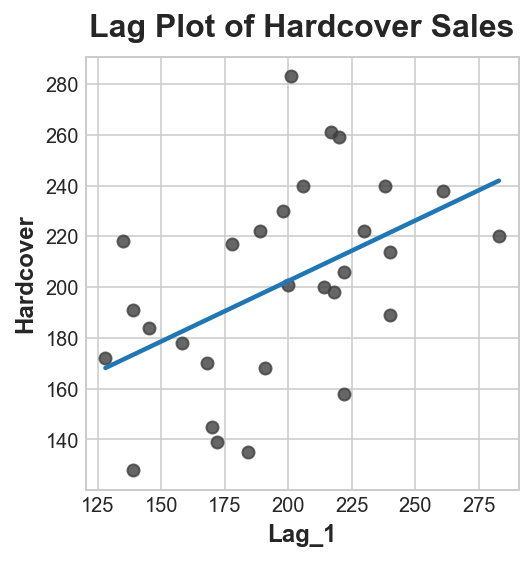

In [6]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

Você pode ver no gráfico de defasagem que as vendas em um dia (capa dura) estão correlacionadas com as vendas do dia anterior (Lag_1). Quando você vê um relacionamento como esse, sabe que um recurso de atraso será útil.

De maneira mais geral, os recursos de atraso permitem modelar a dependência serial. Uma série temporal tem dependência serial quando uma observação pode ser prevista a partir de observações anteriores. Em vendas de capa dura, podemos prever que vendas altas em um dia geralmente significam vendas altas no dia seguinte.

Adaptar algoritmos de aprendizado de máquina a problemas de séries temporais é principalmente sobre engenharia de recursos com o índice de tempo e atrasos. Na maior parte do curso, usamos regressão linear por sua simplicidade, mas esses recursos serão úteis em qualquer algoritmo que você escolher para sua tarefa de previsão.

### Example - Tunnel Traffic

Túnel Tráfego é uma série temporal que descreve o número de veículos que passam pelo Túnel Baregg na Suíça todos os dias de novembro de 2003 a novembro de 2005. Neste exemplo, vamos praticar a aplicação de regressão linear a recursos de intervalo de tempo e recursos de atraso.

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("pasta/tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


- Time-step feature

Desde que a série temporal não tenha **datas ausentes**, podemos criar uma dummy de tempo contando a duração da série.

In [9]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


O procedimento para ajustar um modelo de regressão linear segue as etapas padrão do scikit-learn.

In [10]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

O modelo realmente criado é (aproximadamente): Veículos = 22,5 * Tempo + 98176. A plotagem dos valores ajustados ao longo do tempo nos mostra como o ajuste da regressão linear à dummy de tempo cria a linha de tendência definida por esta equação.

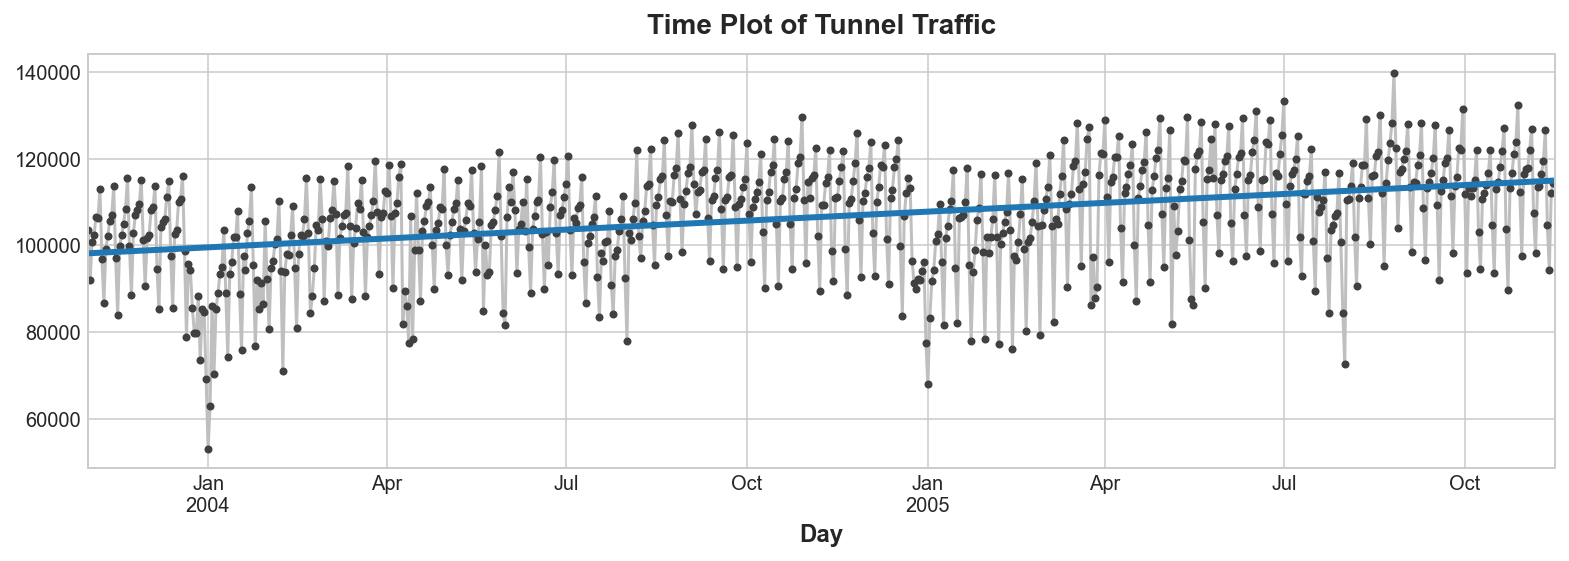

In [11]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

- Lag feature

In [12]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


Ao criar recursos de atraso, precisamos decidir o que fazer com os valores ausentes produzidos. Preenchê-los é uma opção, talvez com 0,0 ou "preenchimento" com o primeiro valor conhecido. Em vez disso, apenas descartaremos os valores ausentes, certificando-nos de descartar também os valores no destino das datas correspondentes.

In [13]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

O gráfico de defasagem nos mostra quão bem conseguimos ajustar a relação entre o número de veículos de um dia e o número do dia anterior.

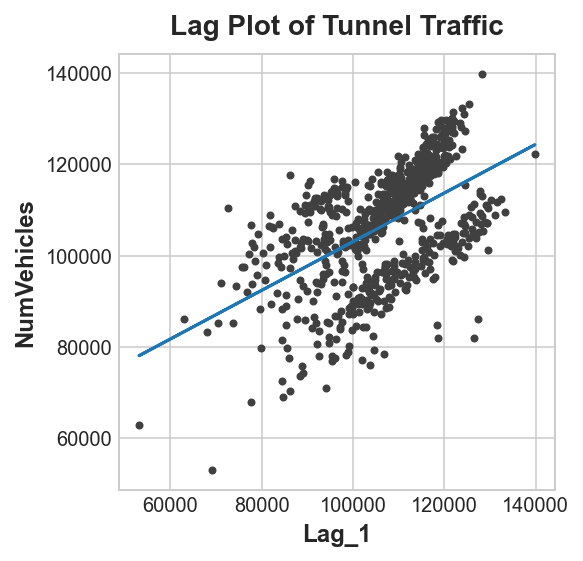

In [14]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

O que essa previsão de um recurso de atraso significa sobre quão bem podemos prever a série ao longo do tempo? O gráfico de tempo a seguir nos mostra como nossas previsões agora respondem ao comportamento das séries no passado recente.

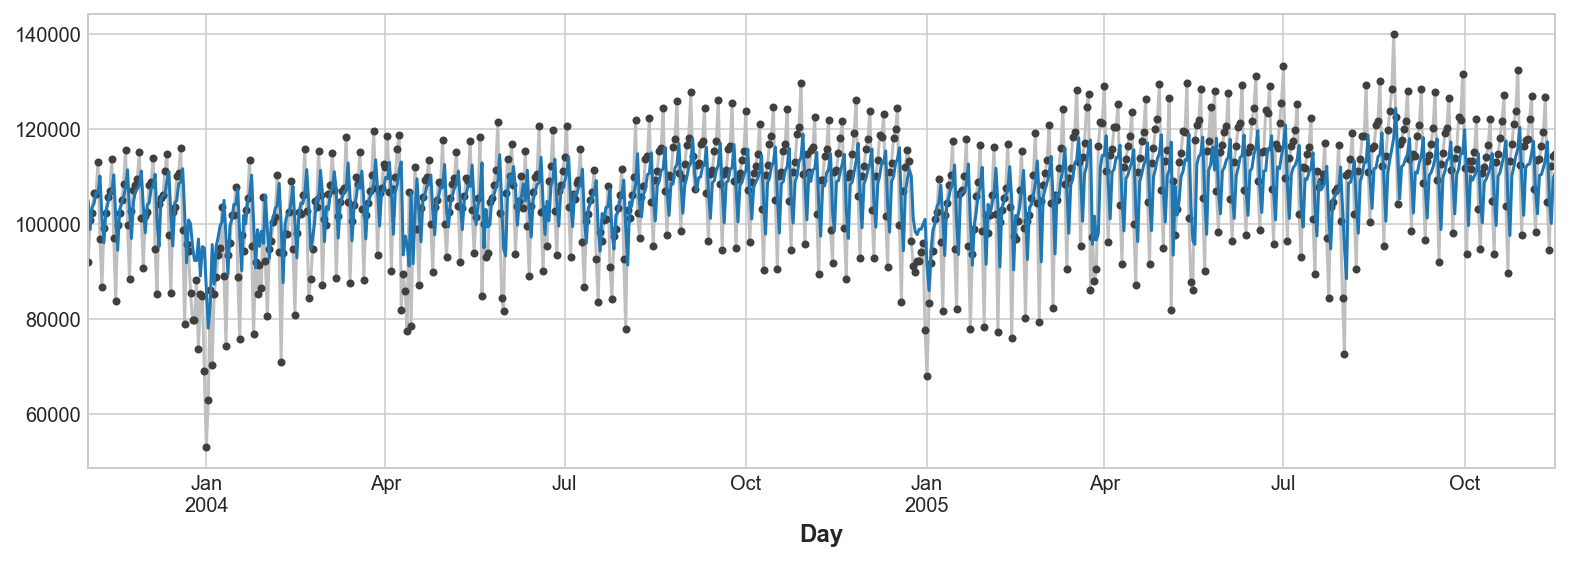

In [20]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

Os melhores modelos de séries temporais geralmente incluem alguma combinação de recursos de passo de tempo e recursos de atraso.

Uma mudança de N etapas no Tempo corresponde a uma mudança média de (N * peso) na variavel target.

Interpretar os coeficientes de regressão pode nos ajudar a reconhecer a dependência serial em um gráfico de tempo. Considere o alvo do modelo = peso * lag_1 + erro, em que erro é ruído aleatório e peso é um número entre -1 e 1. O peso neste caso informa a probabilidade de o próximo passo de tempo ter o mesmo sinal do passo de tempo anterior : um peso próximo a 1 significa que o alvo provavelmente terá o mesmo sinal da etapa anterior, enquanto um peso próximo a -1 significa que o alvo provavelmente terá o sinal oposto.